In [1]:
%pylab inline
from analysis_toolbox import *
from qualityBaseline import *
import pandas as pd 
from scipy.optimize import minimize
bb_info = pd.read_csv('../../crowd-seg/analysis/computed_my_COCO_BBvals.csv')
obj_sorted_tbl =  bb_info[bb_info['Jaccard [COCO]']!=-1][bb_info['Jaccard [COCO]']!=0][bb_info['Jaccard [Self]']!=0].sort('object_id')
object_id_lst  = list(set(obj_sorted_tbl.object_id))
img_info,object_tbl,bb_info,hit_info = load_info()

Populating the interactive namespace from numpy and matplotlib


In [2]:
def abslogN(param):
    '''
    Drawing from normal distribution with prior (std) as param, with mean centered at 0
    log without nan; nan if value <0
    '''
    return log(abs(random.normal(0,param)))
def compute_phii(metric):
    '''
    phi value compared to ground truth 
    '''
    if metric in ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',"NME [COCO]",\
       'Precision [Self]','Recall [Self]','Jaccard [Self]',"NME [Self]"]:
        return 1
    elif metric in ["Num Points","Area Ratio"]:
        return 0

In [27]:
# T = total number of tasks
# n = number of points in bounding box
# m = number of metric functions of interest
# W = total number of workers 
#metric functions of interest 
#metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',"NME [COCO]","Num Points",\
#               'Precision [Self]','Recall [Self]','Jaccard [Self]',"NME [Self]","Area Ratio"]
metrics_lst = ['Precision [COCO]','Recall [COCO]']
worker_lst = unique(bb_info.worker_id)
#Parameters: Priors
beta,gamma,theta = [1,1,1]
# Hidden variables 
m = len(metrics_lst)
T = len(img_info)
W = len(worker_lst)
z = np.ones((50,T))# n x T
D = np.zeros((m,T))# m x T
b = np.zeros((m,W))# m x W
c = np.zeros((m,W))# m x W

In [28]:
# equally weigh Di and cj
w1=0.5
w2=0.5

In [29]:
def Q(params):
    beta,gamma,theta = params
    loglikelihood=[]
    # Loop through all Phi metrics 
    for k in range(m):
        #Loop through all task
        logpD_lst =[]
        for j in range(W):
            logpD_lst.append(abslogN(theta))
        logpD =sum(logpD_lst)
        #Loop through all workers
        worker_quality_prob=[]
        for i in range(T):
            worker_quality_prob.append(abslogN(beta)+ abslogN(gamma))
            logphiij_lst = []
            # Ji is the list of workers that annotated object i
            Ji = list(obj_sorted_tbl[obj_sorted_tbl["object_id"]==i].worker_id)
            for j in Ji : 
                j = int(np.where(worker_lst==j)[0])
                phii=compute_phii(metrics_lst[k])
                mu = phii-b[k][j]
                sig = sqrt(w1*D[k][i]**2+w2*c[k][j]**2)
                if sig==0: sig=1e-5
                logphiij_lst.append(log(abs(random.normal(mu,sig))))
        logphiij = sum(logphiij_lst)
        loglikelihood.append(sum(worker_quality_prob)+logphiij+logpD)
    # sum of likelihood over all the Phi_k functions 
    return -sum(loglikelihood)

In the M step you maximize the posterior by minimizing the -log likelihood. Then using the maximized parameters $\theta^\prime$, update hidden var Di,bj,cj, by drawing your distribution based on those maximized parameters. zi will not be updated.

In [25]:
Q([beta,gamma,theta])

306.01358064382237

In [9]:
bnds= ((0, None), (0, None),(0, None))
results = minimize(Q,[200,200,200],method='tnc',bounds=bnds)#, options={'factr' : 1e7})

In [10]:
results

     fun: -1022.1637989726872
     jac: array([ -2.58093526e+09,  -2.42682874e+09,  -2.99862097e+09])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 5
     nit: 1
  status: 2
 success: True
       x: array([ 199.99999989,  200.00000157,  200.00000095])

this is a bit weird because the optimized parameters are always very close to the initial conditions 

In [13]:
bnds= ((0, None), (0, None),(0, None))
N_iter = 50 #numebr of iterations 
negloglikelihood_lst = []
for i in range(N_iter): 
    print ""
    # E step 
    negloglikelihood = Q([beta,gamma,theta])
    negloglikelihood_lst.append(negloglikelihood)
    # M step
    results = minimize(Q,[200,200,200],method='tnc',bounds=bnds)#, options={'factr' : 1e7})
    beta,gamma,theta = results.x

In [18]:
results

     fun: -1022.3961879225614
     jac: array([  5.82187234e+09,   2.77439877e+09,   4.41009234e+09])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 4
     nit: 1
  status: 2
 success: True
       x: array([ 200.00000011,  200.00000012,  200.00000021])

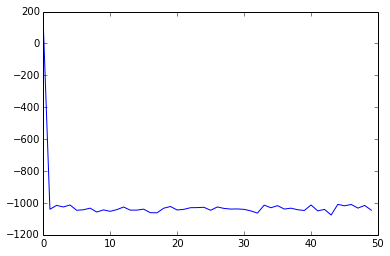

In [17]:
plt.plot(negloglikelihood_lst)